# Init

In [108]:
import os
import math

import numpy as np
import fasttext.util

import matplotlib.pyplot as plt

import nn
import utils


np.seterr(divide='ignore', invalid='ignore')
#np.seterr(divide='raise', invalid='raise')

%matplotlib widget
%matplotlib inline

%load_ext autoreload
%autoreload 2

MODEL_DIM = 64
INNER_DIM = MODEL_DIM * 4

SEQ_LEN = 128 # Max length of input or output sentence
NUM_HEADS = 8


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
embeddings = utils.get_embeddings(["en", "fr"], dim=MODEL_DIM) # using dim 256 instead of 512

en_emb = embeddings["en"]
fr_emb = embeddings["fr"]

print(en_emb.get_dimension())
print(fr_emb.get_dimension())

64
64


In [109]:
def pad_embedding(x, pad_len, embed_dim):
    """Pads a word embedding to a max length"""
    padded = np.zeros((pad_len - x.shape[0], embed_dim))
    return np.concatenate((x, padded))


class TranslationDataset():
    """Dataset for the position encoded and word embedded translations"""
    def __init__(self, inputs, targets, embeddings, pad_len, embed_dim):
        self.inputs = inputs 
        self.targets = targets 
        
        # Encoders for both languages
        emb_in = embeddings["en"]
        emb_tgt = embeddings["fr"]
        
        # Embed all inputs
        self.input_em = []
        for seq in inputs:
            embed = np.array([emb_in.get_word_vector(w) for w in seq.split()])
            embed = pad_embedding(embed, pad_len, embed_dim)
            self.input_em.append(np.array(embed))
            
        # Embed all outputs 
        self.target_em = []
        for seq in targets:
            embed = np.array([emb_tgt.get_word_vector(w) for w in seq.split()])
            embed = pad_embedding(embed, pad_len, embed_dim)
            self.target_em.append(np.array(embed))
    
    def pad_embedding(self, x):
        padded = np.zeros((self.pad_length - x.shape[0], self.embed_dim))
        return np.concatenate((x, padded))

    def __len__(self):
        return (len(self.sequence))

    def __getitem__(self, idx):
        return({
            "input":self.inputs[idx],
            "target":self.targets[idx],
            "input_embedding":self.input_em[idx],
            "target_embedding":self.target_em[idx],
        })
    
data = ["the cat likes oranges", "hello my friend"]
target = ["le chat aime les oranges", "bonjour mon amie"]

dataset = TranslationDataset(data, target, embeddings, SEQUENCE_MAX, MODEL_DIM) 

In [110]:
def pos_encoding(seq):
    """Adds positional encoding to a sequence of word vectors"""
    seq_len = seq.shape[0]
    d_model = seq.shape[1]
    
    encoding = []
    for i in range(seq_len):
        w = 1 / (10000 ** ((2 * i) / d_model))

        wi_s = [math.sin(p * w) * (i % 2) for p in range(d_model)]
        wi_c = [math.cos(p * w) * ((i + 1) % 2) for p in range(d_model)]
        
        encoding.append(np.add(wi_s, wi_c))
        
    encoding = np.array(encoding)
    
    return np.add(encoding, seq)

-0.0174961131801421


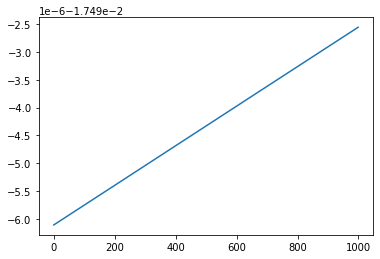

In [131]:
class AttentionHead():
    """Scaled dot product attention head. """
    def __init__(self, embed_dim, n_heads):
        self.embed_dim = embed_dim
        self.output_dim = embed_dim // n_heads
        #self.dim_k = math.sqrt(self.embed_dim // self.output_dim)
        self.dim_k = math.sqrt(self.output_dim)
        
        self.layers = [np.random.randn(self.output_dim, embed_dim) * \
                                 np.sqrt(2 / self.embed_dim) for _ in range(3)]
        
        #TODO find clean alternative
        self.V, self.K, self.Q = self.layers[0], self.layers[1], self.layers[2]
        
        # Useful for calculating gradient
        self.ones = (np.ones((SEQ_LEN, self.output_dim)))
    
    def __call__(self, x, mask=None):
        """Attention forward pass
        Function: softmax(QK^T/sqrt(dim_k) * V)
        """
        # Scaled dot product
        scaled = np.dot(np.dot(self.Q, x.T), np.dot(self.K, x.T).T) / self.dim_k
        
        # Masking (Optional)
        if mask is not None:
            scaled = np.add(mask, scaled)
            
        self.layer_output = np.matmul(nn.softmax(scaled), np.dot(self.V, x.T)).T
        self.layer_output = np.nan_to_num(self.layer_output)
        return(self.layer_output)
    
    def F(self, x):
        """KQ^T/d_k for backprop"""
        return(np.dot(np.dot(self.Q, x.T), np.dot(self.K, x.T).T) / self.dim_k)
    
    def step(self, x, t, alpha=0.0001, eps=1e-9):
        """Step along gradients to update K, Q, V weights."""
        # Softmax derivative
        dS = np.matmul(nn.softmax(self.F(x)), 
                       (np.identity(self.output_dim) - nn.softmax(self.F(x))))
        
        # Cross entropy derivative
        dL = np.divide(-t, self.layer_output)
        dL = dL + ((self.ones - t) / (self.ones - self.layer_output))
        dL[np.isnan(dL)] = 0
        
        # Calculate loss w.r.t weight gradients
        # dL/dK
        dK = np.matmul(self.Q, x.T)
        dK = np.matmul(dK, x).T
        dK = np.diag(1 / self.dim_k * np.kron(dK, np.identity(self.output_dim)))
        
        # dL/dQ
        dQ = np.matmul(self.K, np.matmul(x.T, x))
        dQ = np.kron(np.identity(self.output_dim), self.K)
        dQ = np.diag(1 / self.dim_k * dQ)
        
        # dL/dV
        # TODO
        
        # Calc deltas and update weights
        del_K = np.nan_to_num(np.matmul(dL, np.nan_to_num(dS)))
        self.K -= np.einsum("ki,j->ij", del_K, dK) * alpha
        
        del_Q = np.nan_to_num(np.matmul(dL, dS))
        self.Q -= np.einsum("ki,j->ij", del_Q, dQ) * alpha

        
x = dataset[0]["input_embedding"]
t = dataset[0]["input_embedding"]

head = AttentionHead(MODEL_DIM, NUM_HEADS)

t = t[:,0:8]

output = head(x)
print(nn.cross_entropy(output, t))

outputs = []
#print(A.layers[0].weights)
for _ in range(1000):
    head.step(x, t[:,0:8])
    output = head(x)
    outputs.append(nn.cross_entropy(output, t))
    
plt.plot(outputs)


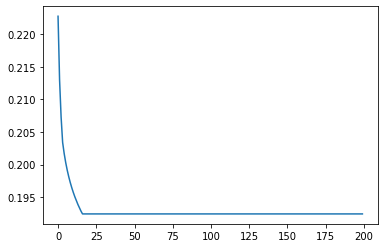

In [113]:
class MultiheadAttention():
    """Multiheaded attention transformer block"""
    def __init__(self, embed_dim=MODEL_DIM, n_heads=NUM_HEADS, 
                 seq_len=SEQUENCE_MAX, masked=False):
        # Class vars
        self.embed_dim = embed_dim
        self.attn_dim = embed_dim // n_heads
        
        # Create all heads and weights for multiheaded attention
        self.heads = [AttentionHead(embed_dim, n_heads) for _ in range(n_heads)]
        self.O = np.random.randn(embed_dim, embed_dim) * math.sqrt(2 / (embed_dim * seq_len))
        
        # If the attention block is masked
        self.mask = None
        if masked:
            self.mask = np.ones((self.attn_dim, self.attn_dim)) * -np.inf
            self.mask = np.triu(self.mask, k=1)
    
    def __call__(self, x):
        """Forward passes through concatenated heads and matmuls by weights"""
        h_cat = np.concatenate([h(x, self.mask) for h in self.heads], axis=1)
        self.layer_output = np.nan_to_num(np.matmul(h_cat, self.O.T))
        return(self.layer_output)
        
    def backprop(self, x, target, alpha=0.001):
        """Makes one step along each gradient of each attention head"""
        #for i, h in enumerate(self.heads):
        #    t = target[:,0 + i * self.attn_dim:(1 + i) * self.attn_dim] #0-32, 33-64, etc.
        #    h.step(x, t, alpha)
        
        # Derivative of layer given output from multihead attention
        #pred = self.__call__(x)
        #delta = -(target / pred) + (np.ones(target.shape) - target) / \
        #                           (np.ones(pred.shape) - pred)
        #delta[np.isnan(delta)] = 0
        #self.O -= np.matmul(pred.T, delta) * alpha
        self.O -= np.ones(self.O.shape)
        
        
x = dataset[0]["input_embedding"]
t = dataset[0]["input_embedding"]

attn = MultiheadAttention(MODEL_DIM, NUM_HEADS)

output = attn(x)
#print(output.shape)
#print(nn.cross_entropy(output, t))

outputs = []
for _ in range(200):
    attn.backprop(x, t)
    output = attn(x)
    loss = nn.cross_entropy(output, t)
    outputs.append(loss)
    
plt.plot(outputs)


In [114]:
class FFN(nn.Net):
    """Position-wise feed forward nueral network"""
    def __init__(self, embed_dim=MODEL_DIM, inner_dim=INNER_DIM, sequence_max=SEQUENCE_MAX):
        super(FFN, self).__init__()
        self.L1 = nn.LinearLayer(embed_dim, inner_dim, sequence_max)
        self.L2 = nn.LinearLayer(inner_dim, embed_dim, sequence_max)
        
        self.layers = [
            self.L1,
            self.L2,
        ]
    
    def __call__(self, x):
        """ReLU(xW1 + b1)W2 + b2"""
        x = self.L2(np.maximum(self.L1(x), 0))
        
        return x

In [115]:
#TODO implement layer norm
def layer_norm(layer):
    std = np.std(layer)
    mean = np.mean(layer)
    print(std, mean)
    print(layer)


In [116]:
class EncoderBlock():
    
    """Encoder block for the transformer.
    Args:
            embed_dim (string): Directory with all the images.
            n_heads (string): Path to the csv file with annotations.
            sequence_max (int):
            inner_dim (int):
    """
    def __init__(self, embed_dim=MODEL_DIM, n_heads=NUM_HEADS, 
                 inner_dim=INNER_DIM, sequence_max=SEQ_LEN):
        self.embed_dim = embed_dim
        self.n_heads = n_heads 
        self.seq_len = seq_len 
        
        self.multihead_attn = MultiheadAttention(embed_dim, n_heads)
        self.feedforward = FFN(embed_dim, inner_dim, seq_len)
    
    def temp_add_norm(self, x, y):
        # TODO replace with layer norm function
        x = np.add(x, y) 
        return (x / np.sqrt(np.sum(x**2))).T
        
    def __call__(self, x):
        y = self.multihead_attn(x)
        x = self.temp_add_norm(x, y.T)
        
        y = self.feedforward(x)
        x = self.temp_add_norm(x, y)
        
        return x

#multihead_attn = MultiheadAttention()
#ffn = FFN()
#
#x = dataset[0]["input_embedding"]
#t = dataset[0]["input_embedding"]
#
#x = multihead_attn(x)
#
##multihead_attn.backprop(x, t)
#
#x = multihead_attn(x)


#x = ffn(t.T)
#
#
#ffn.backprop(x, t)
#print(nn.loss(x, t))

#for i in range(x.shape[1]):
#    print(x[:,i].shape, t.T[:,i].shape)
#    ffn.backprop(x[:,i], t.T[:,i])
#    print(nn.loss(x, t.T))
    

#layer_norm(x)
#enc_block = EncoderBlock()